In [54]:
import pandas as pd
from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

class data_holder():
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self.df = self.data.copy()

    def basic_eda(self):
        # count the number of duplicated rows, then grab all NaN (i.e., null) rows
        # in the dataframe
        num_duplicated = self.df.duplicated().sum()
        is_nan = self.df.isnull()
        
        # count the total number of rows that contain *at least one* null value
        num_null_rows = is_nan.any(axis=1).sum()
        
        # count the total number of null values across *all* rows and *all* columns
        # (i.e., a sum of a sum)
        num_total_null = self.df.isnull().sum().sum()

        # construct a named tuple to represent each row in the exploratory data
        # analysis summary
        EDARow = namedtuple("EDARow", ["Name", "Value", "Notes"])

            # build the list of exploratory data analysis rows
        rows = [
            EDARow("Samples", self.df.shape[0], ""),
            EDARow("Features", self.df.shape[1], ""),
            EDARow("Duplicate Rows", num_duplicated, ""),
            EDARow("Rows with NaN", num_null_rows, "{:.2f}% all rows".format(
                (num_null_rows / self.df.shape[0]) * 100)),
            EDARow("Total NaNs", num_total_null, "{:.2f}% feature matrix".format(
                (num_total_null / (self.df.shape[0] * self.df.shape[1])) * 100)),
        ]
            
        # build and return our exploratory data analysis dataframe
        return pd.DataFrame(rows, columns=["Name", "Value", "Notes"])

    def summarize_data(self):
        # initialize a summary dataframe consiting of the original dataframe's
        # column names and data types
        summary = pd.DataFrame(self.df.dtypes, columns=["dtypes"])
        
        # reset the summary index, rename the "index" column to "Name", and then
        # remove the "index" column
        summary = summary.reset_index()
        summary["Name"] = summary["index"]
        summary = summary[["Name", "dtypes"]]
        
        # count the number of (1) null values for each column, and (2) the unique
        # values in each column
        summary["Missing"] = self.df.isnull().sum().values
        summary["Uniques"] = self.df.nunique().values
        
        # return the summary dataframe
        return summary



In [55]:
disasters = data_holder('1970-2021_DISASTERS.xlsx - emdat data.csv')

df_overview = disasters.basic_eda()
df_overview.head()

,Name,Value,Notes
0,Samples,14644,
1,Features,47,
2,Duplicate Rows,0,
3,Rows with NaN,14644,100.00% all rows
4,Total NaNs,308558,44.83% feature matrix


In [56]:
df_summary = disasters.summarize_data()
print(df_summary)

                               Name   dtypes  Missing  Uniques
0                            Dis No   object        0    14644
1                              Year    int64        0       52
2                               Seq    int64        0     1265
3                             Glide   object    13063     1086
4                    Disaster Group   object        0        1
5                 Disaster Subgroup   object        0        6
6                     Disaster Type   object        0       14
7                  Disaster Subtype   object     2747       27
8               Disaster Subsubtype   object    13600       12
9                        Event Name   object    10999     1488
10                          Country   object        0      228
11                              ISO   object        0      228
12                           Region   object        0       23
13                        Continent   object        0        5
14                         Location   object     1346  

Text(0.5, 1.0, 'Number of Disasters per Country (1970-2021)')

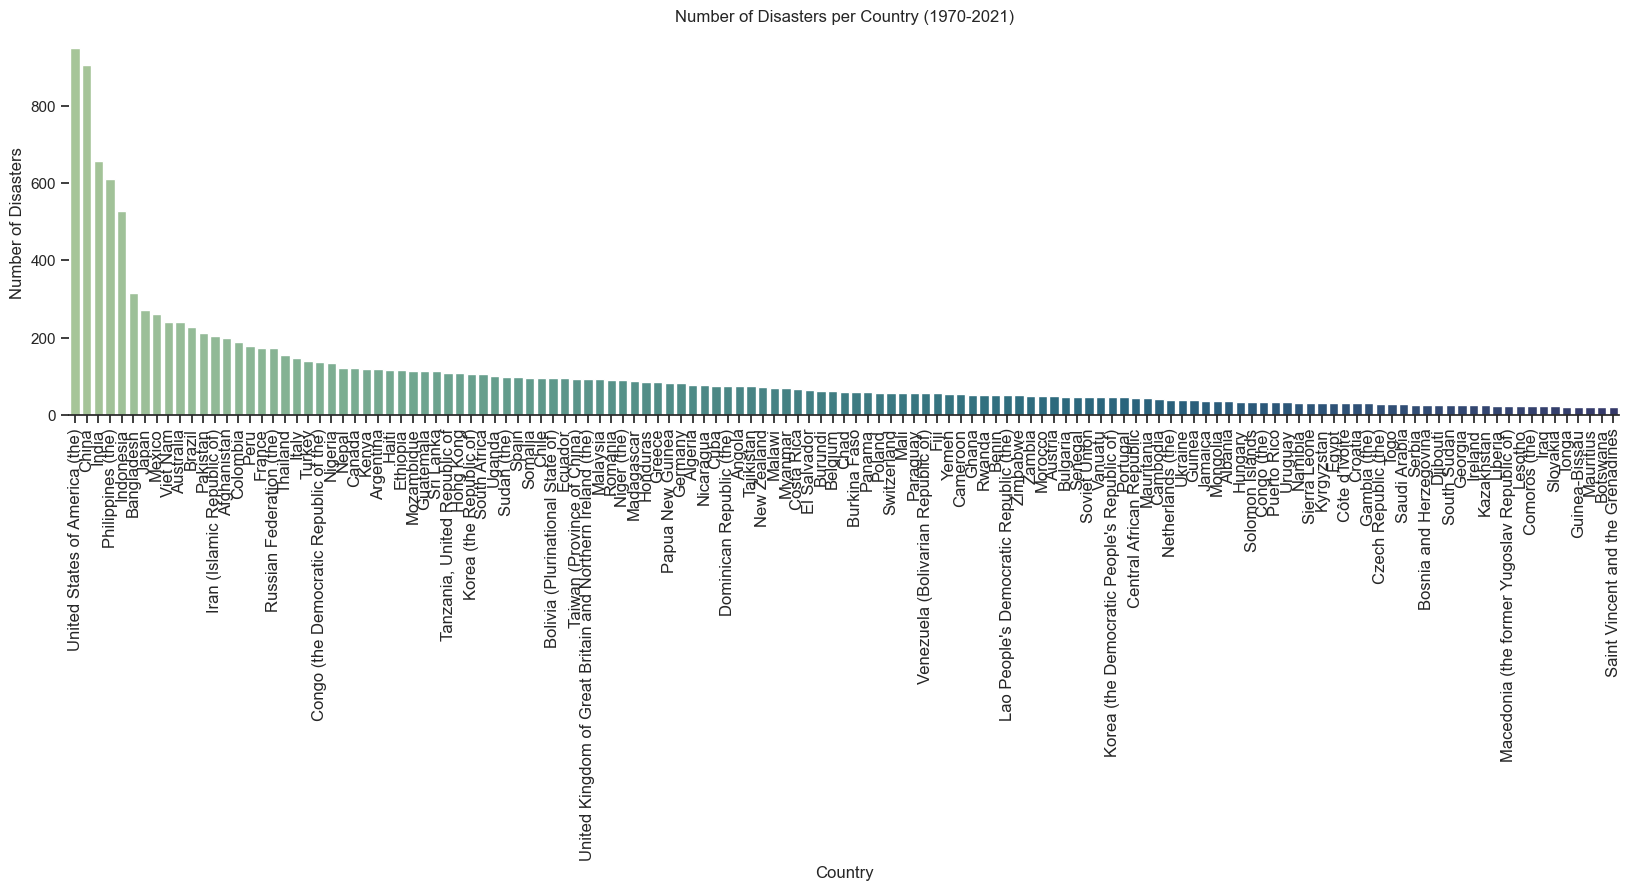

In [62]:
country_counts = disasters.data['Country'].value_counts()
country_counts = country_counts[country_counts >20]

title='Number of Disasters per Country (1970-2021)'
x_label='Country'
y_label="Number of Disasters"
figsize=(20, 5)

# initialize the figure, set the tick information, and update the spines
plt.figure(figsize=figsize)
sns.set_theme(style="ticks", font_scale=1)
plt.xticks(rotation=90, fontsize=12)
sns.despine(top=True, right=True, bottom=False, left=True)

# plot the data
ax = sns.barplot(x=country_counts.index, y=country_counts.values, palette="crest", hue= country_counts.index, legend=False)

# set the x-label, y-label, and title
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.title(title)

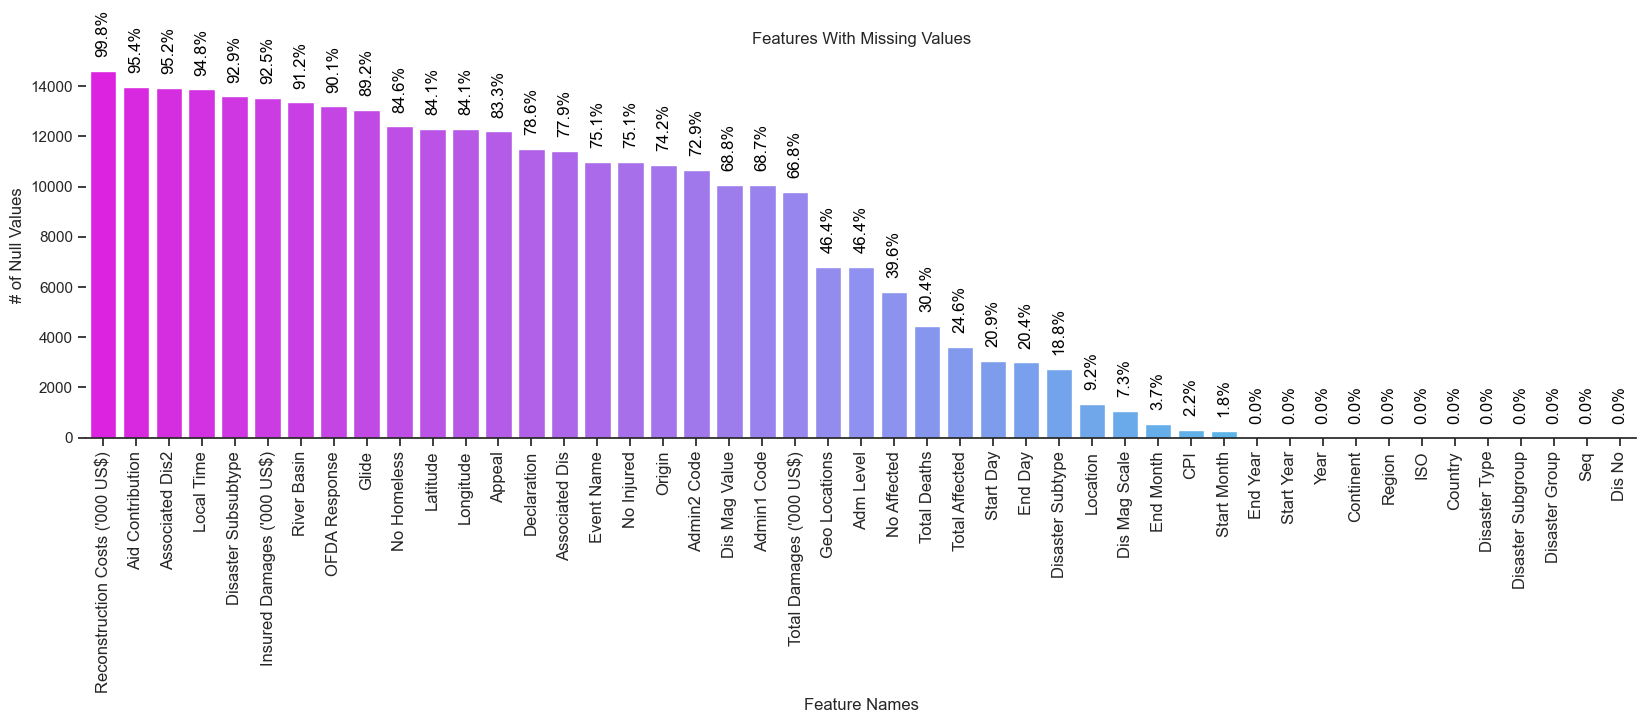

In [28]:
def plot_null_columns(
    df,
    title,
    x_label="Feature Names",
    y_label="# of Null Values",
    figsize=(20, 5)
):
    # count the number of times a given column has a null value
    null_cols = df.isnull().sum().sort_values(ascending=False)
    
    # initialize the figure, set the tick information, and update the spines
    plt.figure(figsize=figsize)
    sns.set_theme(style="ticks", font_scale=1)
    plt.xticks(rotation=90, fontsize=12)
    sns.despine(top=True, right=True, bottom=False, left=True)

    # plot the data
    ax = sns.barplot(x=null_cols.index, y=null_cols, palette="cool_r", hue=null_cols.index, legend=False)

    # set the x-label, y-label, and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)

    # loop over the patches and null column counts
    for (p, count) in zip(ax.patches, null_cols):
        # compute the percentage of the number of rows that have a null value
        # for the current column
        ax.annotate(
            "{:.1f}%".format((count / df.shape[0]) * 100),
            (p.get_x() + (p.get_width() / 2.0), abs(p.get_height())),
            ha="center",
            va="bottom",
            rotation="vertical",
            color="black",
            xytext=(0, 10),
            textcoords="offset points"
        )

# plot the null column counts within the dataset
plot_null_columns(disasters.df, "Features With Missing Values")


In [ ]:
country_counts = disasters.data['Country'].value_counts()
country_counts = country_counts[country_counts >20]

title='Number of Disasters per Country (1970-2021)'
x_label='Country'
y_label="Number of Disasters"
figsize=(20, 5)

# initialize the figure, set the tick information, and update the spines
plt.figure(figsize=figsize)
sns.set_theme(style="ticks", font_scale=1)
plt.xticks(rotation=90, fontsize=12)
sns.despine(top=True, right=True, bottom=False, left=True)

# plot the data
ax = sns.barplot(x=country_counts.index, y=country_counts.values, palette="crest", hue= country_counts.index, legend=False)

# set the x-label, y-label, and title
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.title(title)

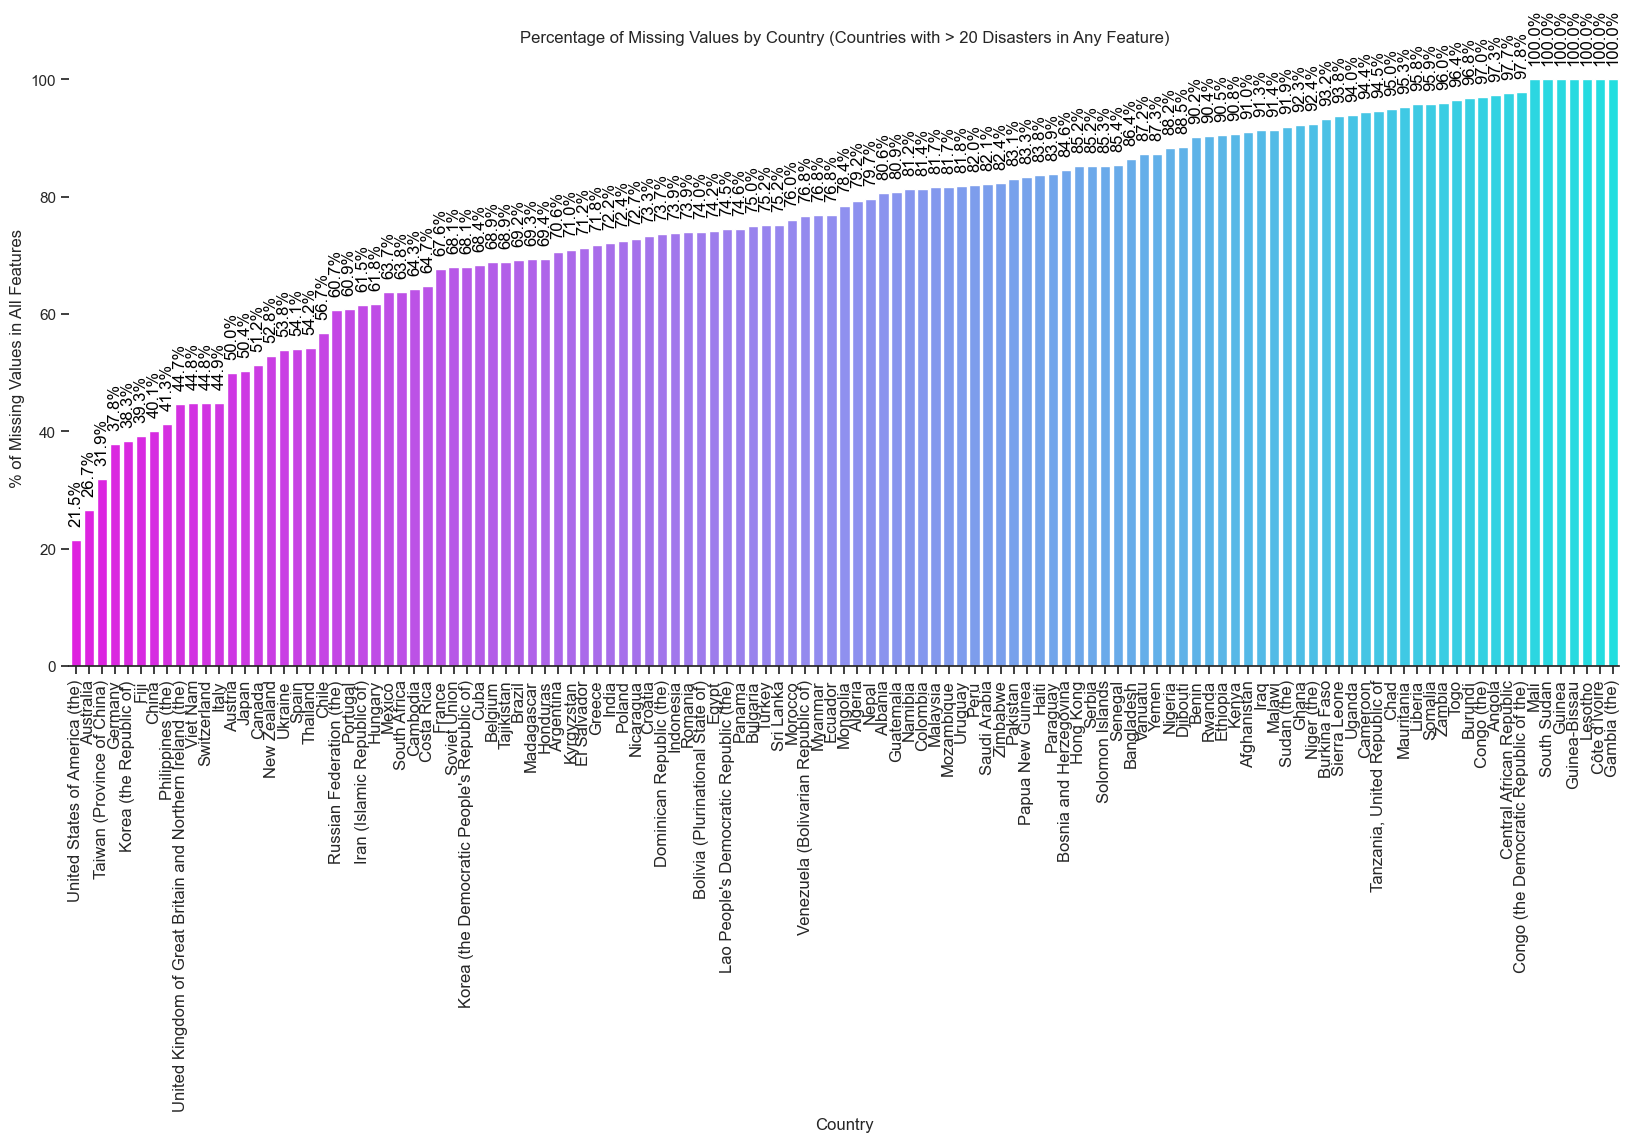

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values_by_country(df, features, title, x_label="Country", y_label="% of Missing Values in All Features", figsize=(20, 8), min_disasters=20):
    # Filter for countries with a minimum number of records that are missing in all specified features
    country_counts = df.groupby('Country').apply(
        lambda x: (x[features].isna().all(axis=1)).sum(),
        include_groups=False
    )
    countries_with_min_disasters = country_counts[country_counts > min_disasters].index
    filtered_df = df[df['Country'].isin(countries_with_min_disasters)]
    
    # Calculate the percentage of records missing in all specified features for each country
    missing_data = filtered_df.groupby('Country').apply(
        lambda x: (x[features].isna().all(axis=1)).mean() * 100,
        include_groups=False)
    
    # Sort by ascending order (least missing values in all features first)
    missing_data_sorted = missing_data.sort_values()
    
    # Initialize the figure
    plt.figure(figsize=figsize)
    sns.set_theme(style="ticks", font_scale=1)
    plt.xticks(rotation=90, fontsize=12)
    sns.despine(top=True, right=True, bottom=False, left=True)
    
    # Plot the data
    ax = sns.barplot(x=missing_data_sorted.index, y=missing_data_sorted.values, palette="cool_r", hue=missing_data_sorted.index, legend=False)
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    # Annotate each bar with the percentage of missing values
    for (p, perc) in zip(ax.patches, missing_data_sorted):
        ax.annotate(
            "{:.1f}%".format(perc),
            (p.get_x() + (p.get_width() / 2.0), p.get_height()),
            ha="center",
            va="bottom",
            rotation="vertical",
            color="black",
            xytext=(0, 10),
            textcoords="offset points"
        )

plot_missing_values_by_country(
    disasters.data,
    features=["Total Damages ('000 US$)", "Reconstruction Costs ('000 US$)", "Insured Damages ('000 US$)"],
    title="Percentage of Missing Values by Country (Countries with > 20 Disasters in Any Feature)"
)


In [73]:
# Print unique values for Disaster Group
disaster_groups = disasters.data['Disaster Group'].unique()
print("Unique values in Disaster Group:")
print(disaster_groups)

# Print unique values for Disaster Type
disaster_types = disasters.data['Disaster Type'].unique()
print("\nUnique values in Disaster Type:")
print(disaster_types)


Unique values in Disaster Group:
['Natural']

Unique values in Disaster Type:
['Flood' 'Storm' 'Drought' 'Landslide' 'Earthquake' 'Epidemic' 'Wildfire'
 'Mass movement (dry)' 'Extreme temperature ' 'Volcanic activity'
 'Insect infestation' 'Impact' 'Animal accident' 'Glacial lake outburst']


In [77]:
# define the disaster type columns we are interested then
disaster_cols = [
    "Disaster Subgroup",
    "Disaster Type",
    "Disaster Subtype",
    "Disaster Subsubtype",
]

# grab the disaster data from the dataframe
disaster_df = disasters.df[disaster_cols]

# fill any null values with an empty string (implying that no subgroups or
# subtypes exist for the current value)
disaster_df = disaster_df.fillna(value={
    "Disaster Subtype": "NA",
    "Disaster Subsubtype": "NA",
})

# construct the final dataframe which displays a hierarchical overview of the
# disaster types, including the counts for each one
disaster_df = pd.DataFrame(
    disaster_df.groupby(disaster_cols).size().to_frame("count")
)

disaster_df


count
Disaster Subgroup Disaster Type         Disaster Subtype                 Disaster Subsubtype           
Biological        Animal accident       NA                               NA                           1
                  Epidemic              Bacterial disease                NA                         744
                                        NA                               NA                         137
                                        Parasitic disease                NA                          46
                                        Viral disease                    NA                         509
                  Insect infestation    Grasshopper                      NA                          16
                                        Locust                           NA                          59
                                        NA                               NA                          18
Climatological    Drought               Drought                          NA                         684
                                        NA                               NA                           1
                  Glacial lake outburst NA                               NA                           2
                  Wildfire              Forest fire                      NA                         303
                                        Land fire (Brush, Bush, Pasture) NA                         115
                                        NA                               NA                          34
Extra-terrestrial Impact                NA                               NA                           1
Geophysical       Earthquake            Ground movement                  NA                        1097
                                        NA                               NA                           2
                                        Tsunami                          NA                          38
                  Mass movement (dry)   Avalanche                        NA                           5
                                        Landslide                        Mudslide                     5
                                                                         NA                          22
                                        NA                               NA                           1
                                        Rockfall                         NA                           7
                                        Subsidence                       Sudden subsidence            1
                  Volcanic activity     Ash fall                         NA                         203
                                        Lava flow                        NA                           9
                                        NA                               NA                           8
                                        Pyroclastic flow                 NA                           2
Hydrological      Flood                 Coastal flood                    NA                          81
                                        Flash flood                      NA                         770
                                        NA                               NA                        1788
                                        Riverine flood                   NA                        2633
                  Landslide             Avalanche                        NA                         104
                                                                         Winter storm/Blizzard        2
                                        Landslide                        NA                         498
                                        Mudslide                         NA                          75
                                        NA                               NA                          30
                                        Ro

In [83]:
#Exclude anything not climate related:
#Geophysical
#Extra-terrestial
#Biological (can be argued that this should be included, but not as directly related to the climate, rather our population etc etc)


#Want to include:
#Meteorological, Hydrological, Climatological, 


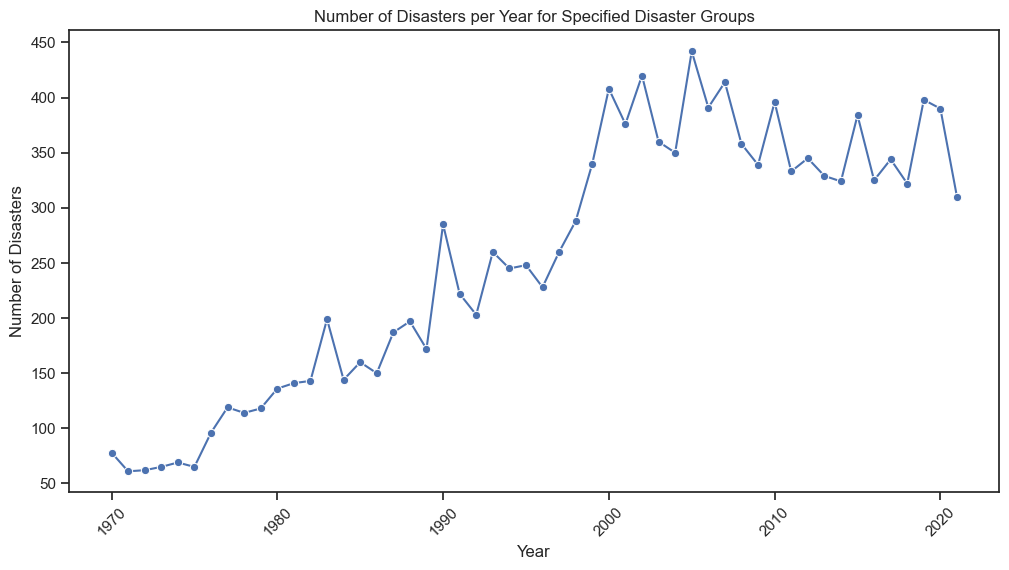

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_disasters_per_year(df, year_column, filter_column, filter_values, title, x_label="Year", y_label="Number of Disasters"):
    # Filter the dataset based on specified values in a feature
    filtered_df = df[df[filter_column].isin(filter_values)]
    
    # Count the number of disasters per year
    disasters_per_year = filtered_df.groupby(year_column).size()
    
    # Initialize the figure
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="ticks", font_scale=1)
    
    # Plot the data
    ax = sns.lineplot(x=disasters_per_year.index, y=disasters_per_year.values, marker="o", color="b")
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    plt.xticks(rotation=45)
    plt.show()

# Specify the values to filter for and call the function
filter_values = ["Geophysical", "Meteorological", "Hydrological", "Climatological"]  # Example filter for certain Disaster Groups or Types
plot_disasters_per_year(
    df=disasters.df,
    year_column="Year",            # Replace with the correct column name for years in your dataset
    filter_column="Disaster Subgroup", # Column to filter (e.g., 'Disaster Group' or 'Disaster Type')
    filter_values=filter_values,
    title="Number of Disasters per Year for Specified Disaster Groups"
)


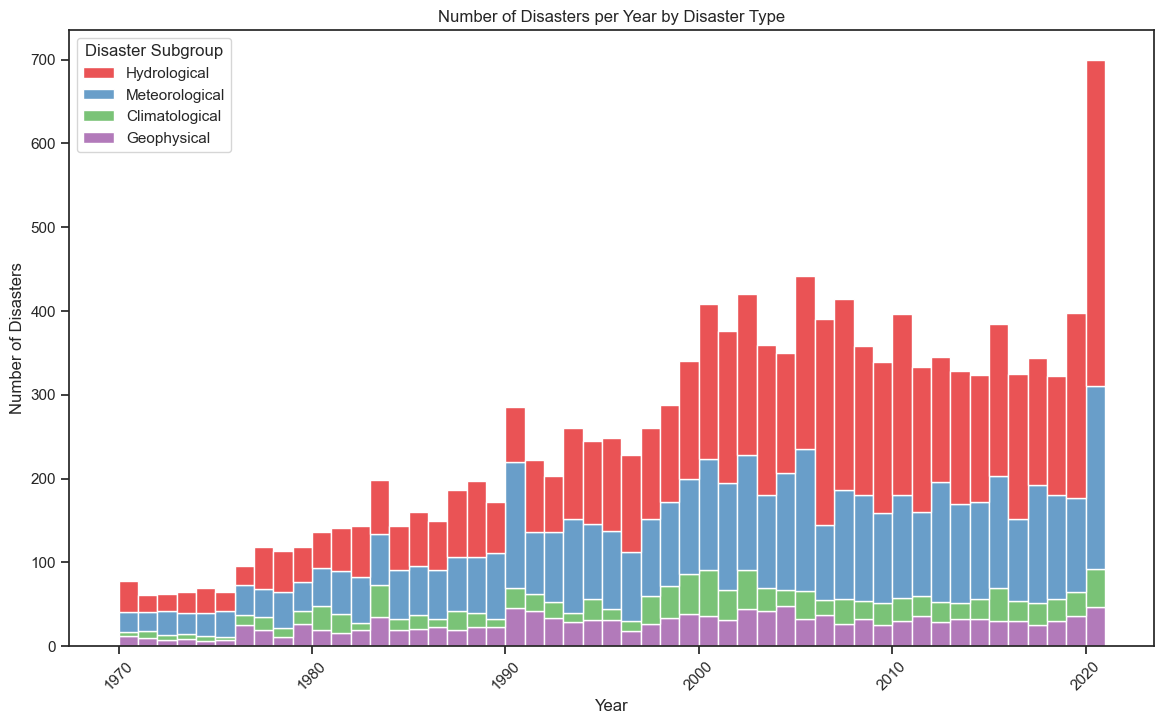

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_disasters_histogram(df, year_column, feature_column, filter_column, filter_values, title, x_label="Year", y_label="Number of Disasters"):
    # Filter the dataset based on specified values in a feature
    filtered_df = df[df[filter_column].isin(filter_values)]
    
    # Initialize the figure
    plt.figure(figsize=(14, 8))
    sns.set_theme(style="ticks", font_scale=1)
    
    # Create a histogram with hue to differentiate between feature categories
    ax = sns.histplot(
        data=filtered_df,
        x=year_column,
        hue=feature_column,
        multiple="stack",  # Stacks the bars for each category within the year
        palette="Set1",    # Selects a color palette for different categories
        binwidth=1         # Bin width of 1 to get each year as a separate bin
    )
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    plt.xticks(rotation=45)
    plt.show()

# Specify the values to filter for and call the function
filter_values = ["Geophysical", "Meteorological", "Hydrological", "Climatological"]  # Example filter for certain Disaster Groups or Types
plot_disasters_histogram(
    df=disasters.data,
    year_column="Year",           # Replace with the correct column name for years in your dataset
    feature_column="Disaster Subgroup", # The feature to use for coloring (e.g., 'Disaster Type')
    filter_column="Disaster Subgroup", # Column to filter (e.g., 'Disaster Group')
    filter_values=filter_values,
    title="Number of Disasters per Year by Disaster Type"
)

# Specify the values to filter for and call the function



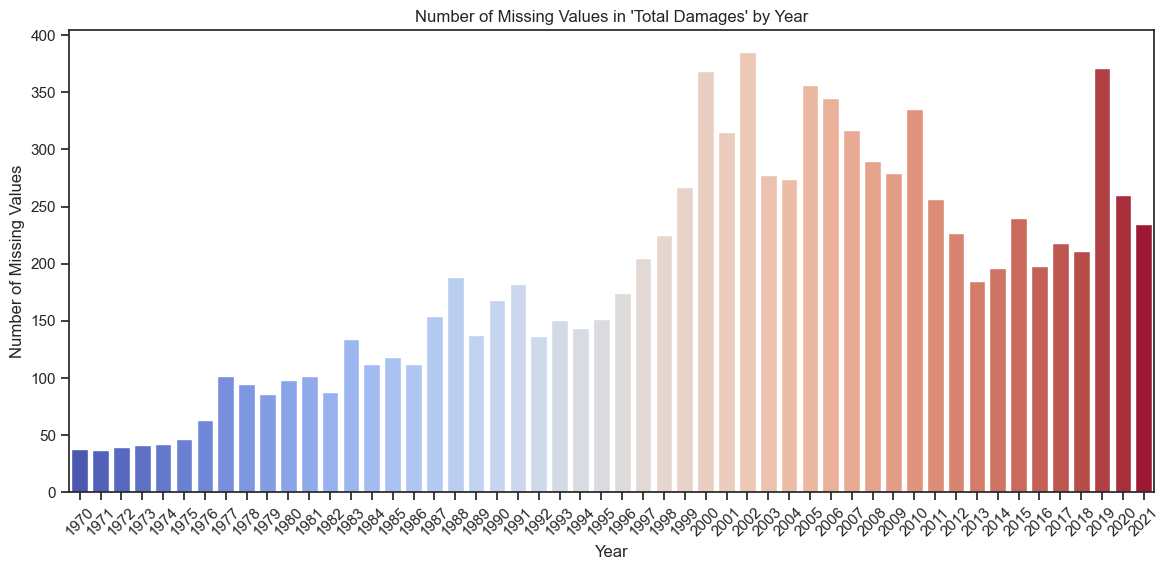

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_by_year(df, year_column, feature_column, title, x_label="Year", y_label="Number of Missing Values", figsize=(14, 6)):
    # Check for missing values in the specified feature
    df['Missing'] = df[feature_column].isna()
    
    # Group by year and sum the missing values for each year
    missing_by_year = df.groupby(year_column)['Missing'].sum()
    
    # Initialize the figure
    plt.figure(figsize=figsize)
    sns.set_theme(style="ticks", font_scale=1)
    
    # Plot the missing values by year using a barplot or lineplot
    ax = sns.barplot(x=missing_by_year.index, y=missing_by_year.values, palette="coolwarm", hue=missing_by_year.index, legend=False)
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    plt.xticks(rotation=45)
    plt.show()

# Example: Plot missing values in the 'Total Damages' feature by year
plot_missing_by_year(
    df=disasters.data,  # Your DataFrame
    year_column="Year", # The column for years
    feature_column="Total Damages ('000 US$)", # The feature for which you want to track missing values
    title="Number of Missing Values in 'Total Damages' by Year"
)


I want to check if any increase in damages recently are due to missing values in earlier years. But in fact we seemingly see an increase in missing values here for more modern disasters

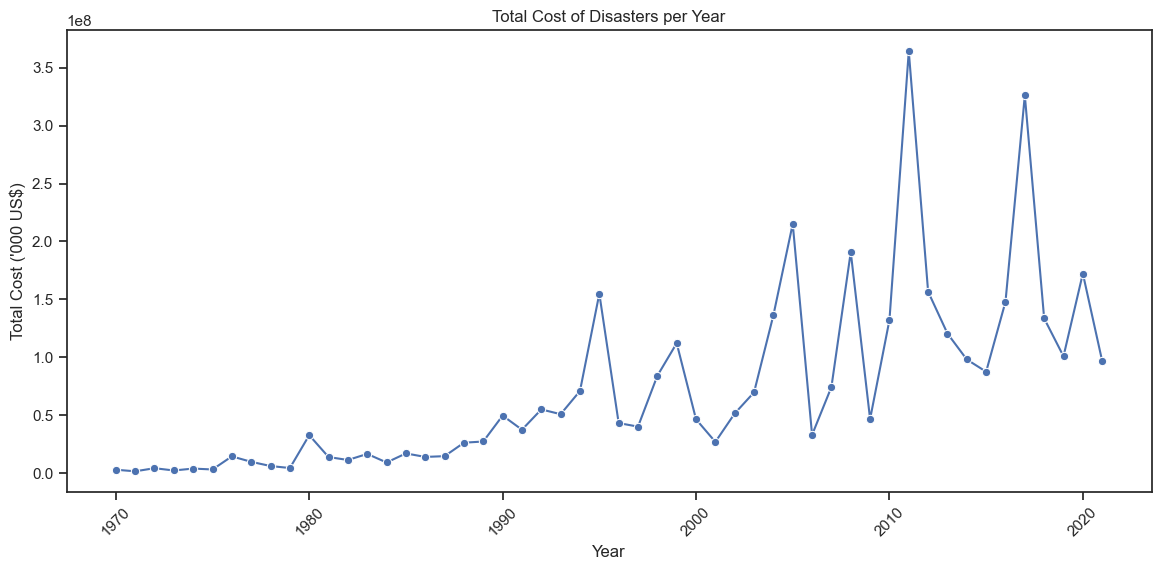

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cost_by_year(df, year_column, cost_column, filter_column, filter_values, title, x_label="Year", y_label="Total Cost ('000 US$)", figsize=(14, 6)):
    # Filter the dataset based on specified values in a feature
    filtered_df = df[df[filter_column].isin(filter_values)]
    
    # Aggregate the total cost of disasters per year
    cost_by_year = filtered_df.groupby(year_column)[cost_column].sum()
    
    # Initialize the figure
    plt.figure(figsize=figsize)
    sns.set_theme(style="ticks", font_scale=1)
    
    # Plot the total cost by year
    ax = sns.lineplot(x=cost_by_year.index, y=cost_by_year.values, marker="o", color="b")
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    plt.xticks(rotation=45)
    plt.show()

# Example usage:
filter_values = ["Geophysical", "Meteorological", "Hydrological", "Climatological"]  # Example filter for certain Disaster Groups
plot_cost_by_year(
    df=disasters.data,                   # Your DataFrame
    year_column="Year",                  # The column for years
    cost_column="Total Damages ('000 US$)", # The column containing the cost of disasters
    filter_column="Disaster Subgroup",      # The feature to filter (e.g., 'Disaster Group')
    filter_values=filter_values,         # The values to filter by
    title="Total Cost of Disasters per Year"
)


We see an increase in costs despite there being more missing values in recent years. I therefore think it is ok to exclude any missing values and work with what's left